In [1]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


In [2]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]


In [8]:
plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## specify the directory you saved the data and images in
DATA_DIR = os.path.join("..","data")
IMAGE_DIR = os.path.join("..","images")

In [3]:
def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


In [4]:
df = fetch_data("cs-train")

In [5]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [6]:
df_index = convert_to_ts(df)

In [49]:
df_index.tail()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,diff_days
602,2019-06-26,1358,67,999,6420,2019-06,4903.17,606 days
603,2019-06-27,1620,80,944,9435,2019-06,5499.38,606 days
604,2019-06-28,1027,70,607,5539,2019-06,3570.60,606 days
605,2019-06-29,0,0,0,0,2019-06,0.00,606 days
606,2019-06-30,602,27,423,2534,2019-06,1793.98,606 days


In [18]:
# Calculate most revenue, answer is UK.
columns_to_show = ["price"]
pd.pivot_table(df, index= 'country', values=columns_to_show,aggfunc='sum').round(0)\
        .sort_values(by='price', ascending=False).head()

,price
country,
United Kingdom,3521514.0
EIRE,107069.0
Germany,49272.0
France,40565.0
Norway,38495.0


In [50]:
# The number of days between first and last invoice. = 606, so answer is 600
print (df_index['date'][606] - df_index['date'][0])

#datemin = np.datetime64(df_index['date'][0])
#datemax = np.datetime64(df_index['date'][606])
#print (datemax)
#datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')

606 days 00:00:00


In [23]:
# Count unique days, answer to question 2: 
df['invoice_date'].nunique()

495

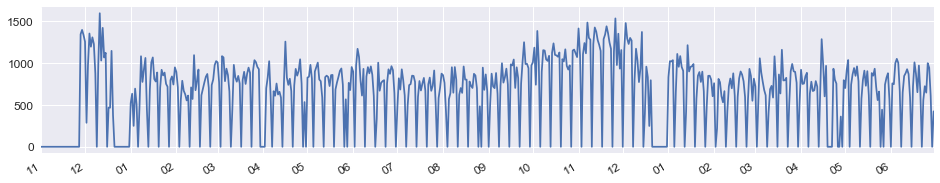

In [82]:
# Answer part 2: in Nov-Dec meest views, purchases en unique_streams


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%m')

# Load a numpy structured array from yahoo csv data with fields date, open,
# close, volume, adj_close from the mpl-data/example directory.  This array
# stores the date as an np.datetime64 with a day unit ('D') in the 'date'
# column.
#with cbook.get_sample_data('goog.npz') as datafile:
#    data = np.load(datafile)['price_data']

fig, ax = plt.subplots(figsize=(16,3))
ax.plot('date', 'unique_streams', data=df_index)

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(years)

# round to nearest years.
datemin = np.datetime64(df_index['date'][0])
datemax = np.datetime64(df_index['date'][606])
#datemin = np.datetime64(data['date'][0], 'Y')
#datemax = np.datetime64(data['date'][-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
#ax.format_xdata = mdates.DateFormatter('%m')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()
